In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image
from scipy.special import expit

In [2]:
#INPUT PARAMETERS:
n_power = 0
dm_mass = 1e-3 #GeV
step_size_cross_section = 2e-26 * pow(dm_mass,0.15)

f_sky = 0.4
theta_fwhm = 1.5 * (np.pi/60./180.)
Tcmb = 2.726
l_min = 2
l_max = 2500

#2e-26 * pow(dm_mass,0.15) <- n=0 
#4e-19 * pow(dm_mass,0.70) <- n=2 
#6e-13 * pow(dm_mass,1.25) <- n=4
list_param = ['omega_b','omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmeff']
list_fiducial = [0.0224, 0.12,      .69,  2.2e-9, 0.96, 0.07, 0]
list_step = [0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

In [3]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl','l_max_scalars': 2500,'lensing': 'yes',
    'omega_b': list_fiducial[0],'omega_dmeff': list_fiducial[1],'h': list_fiducial[2],'A_s' : list_fiducial[3],'n_s' : list_fiducial[4], 'tau_reio' : list_fiducial[5],'sigma_dmeff': list_fiducial[6],
    'm_dmeff': dm_mass,
    'omega_cdm' : 1.0e-10,
    'npow_dmeff': n_power,
    'N_ur':2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'T_ncdm':0.71611
}
# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.lensed_cl(2500)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']
      
Cl_est_kk = []
for i in ell:
    if i < 2:
        Cl_est_kk.append(0)
    else:
        Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*fiducial['pp'][i])

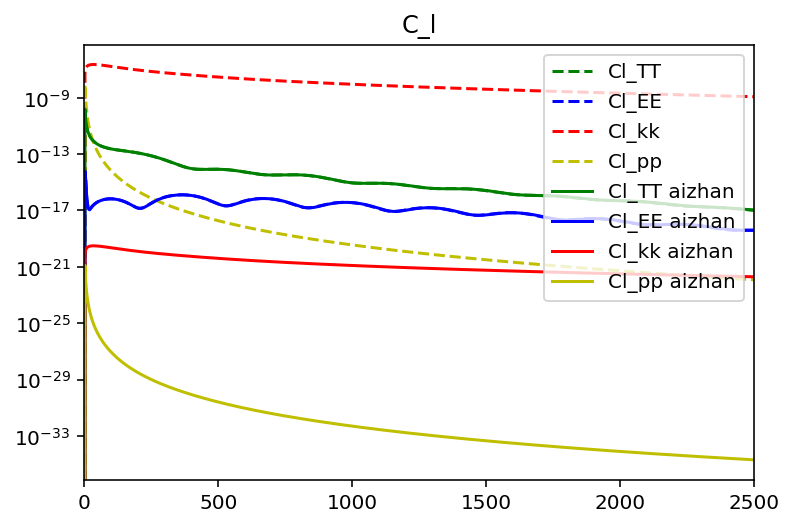

In [4]:
b = np.load('noise/Cl_tt.npy') /((1.0e6*Tcmb)**2)
c = np.load('noise/Cl_ee.npy')/((1.0e6*Tcmb)**2)
d = np.load('noise/Cl_kk.npy') /((1.0e6*Tcmb)**2)

d2 = []
for i in ell:
    if i < 2:
        d2.append(0)
    else:
        d2.append(4*(math.factorial(i-2)/math.factorial(i+2))*d[i])


plt.plot(fiducial['tt'], 'g--',label="Cl_TT")
plt.plot(fiducial['ee'] , 'b--',label="Cl_EE")
plt.plot(Cl_est_kk, 'r--',label="Cl_kk")
plt.plot(fiducial['pp'], 'y--',label="Cl_pp")

plt.plot(b, 'g-',label="Cl_TT aizhan")
plt.plot(c , 'b-',label="Cl_EE aizhan")
plt.plot(d, 'r-',label="Cl_kk aizhan")
plt.plot(d2, 'y-',label="Cl_pp aizhan")

plt.yscale('log')
#plt.ylim(5e-22,1e-18)
plt.xlim(0,2500)
plt.legend(loc="upper right")
plt.title('C_l')
plt.savefig("C_lcompare.png")
plt.show()

In [5]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=2500):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.lensed_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [6]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmeff':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

<ipython-input-6-bdc1f727b3e0>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


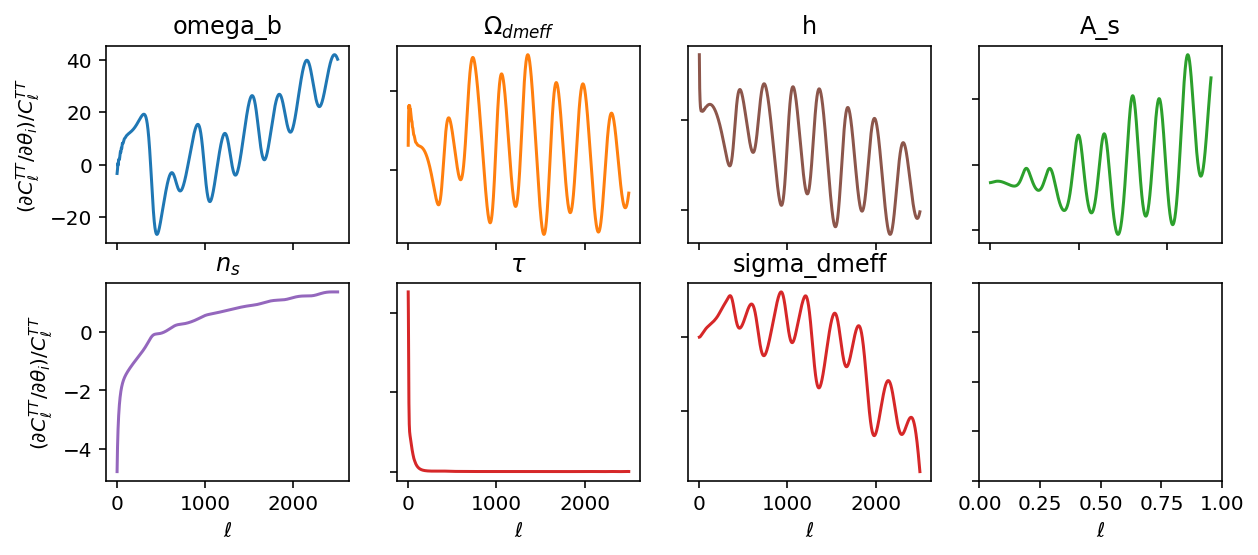

In [7]:
#Plotting Derivatives
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)
fig, axs = plt.subplots(2, 4, figsize=(10,4))

axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')

axs[0, 1].plot(dict_norm_der['omega_dmeff'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmeff}$')

axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')

axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')

axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')

axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')

axs[1, 2].plot(dict_norm_der['sigma_dmeff'], 'tab:red')
axs[1, 2].set_title('sigma_dmeff')

for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#fig.savefig("fisher_plots/derivative_C_l_TT_0.001GeV_n=4_S4.png")


In [8]:
a = np.load('noise/CMB_S4_noise.npy')

nl_tt = a[0] /((1.0e6*Tcmb)**2)
nl_ee = a[1] /((1.0e6*Tcmb)**2)
nl_kk = a[2] /((1.0e6*Tcmb)**2)

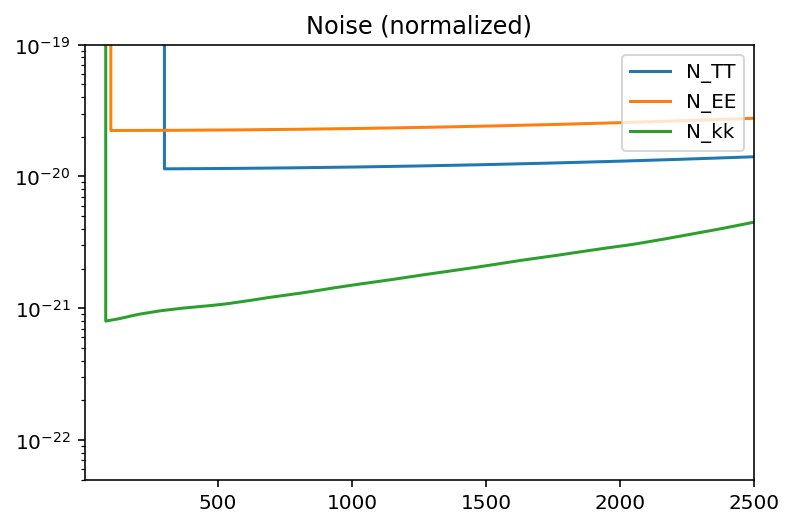

In [9]:
plt.plot(nl_tt, '-',label="N_TT")
plt.plot(nl_ee  , '-',label="N_EE")
plt.plot(nl_kk , '-',label="N_kk")

#plt.plot(N_EE*((1.0e6*Tcmb)**2) , '-',label="Polarization Noise")
#plt.plot(N_KK*((1.0e6*Tcmb)**2) , '--',label="Lensing Noise")
plt.yscale('log')
plt.ylim(5e-23,1e-19)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('Noise (normalized)')
plt.show()

We need:
 
$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$
[Wu et al. 2014](https://arxiv.org/abs/1402.4108)


Computing $C_l$ only using temperature power spectrum for planck baseline. 

$$ \mathbf{C}_{\ell} \equiv 
  \left( {\begin{array}{cc}
   C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)
 $$

Let :
$$   \mathbf{Q}^{i}_{nm} =\, \left( {C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \right)  =
  \left( {\begin{array}{cc}
    C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)^{-1}
   \left( {\begin{array}{cc}
    \frac{\partial C_{\ell}^{TT}}{\partial \theta_i } & \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } & 0 \\
   \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } &\frac{\partial C_{\ell}^{EE}}{\partial \theta_i } & 0 \\
    0 & 0 & \frac{\partial C_{\ell}^{\kappa\kappa}}{\partial \theta_i } \\
  \end{array} } \right)
$$
So that:
$$  F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left[  \mathbf{Q}_{i}  \mathbf{Q}_{j} \right]
$$

In [10]:
dC_lpp = compute_d_cl(list_param_step, params, 'pp', fiducial)

<ipython-input-6-bdc1f727b3e0>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [11]:
def factorial(n):
    fact = 1
    for i in range(1,n+1): 
        fact = fact * i 
    return fact

dC_lkk = {}
for k, array in dC_lpp.items():
    list_a = []
    for l, a in enumerate(array):
        if l < 2:
            list_a.append(0)
        else:
            list_a.append(1.0/4 * (factorial(l+2)/factorial(l-2)) * a)        
    dC_lkk[k] = np.array(list_a)
    
print(dC_lkk)

{'omega_b': array([ 0.00000000e+00,  0.00000000e+00,  1.48209884e-07, ...,
       -1.66774715e-08, -1.66577759e-08, -1.66381026e-08]), 'omega_dmeff': array([ 0.00000000e+00,  0.00000000e+00, -4.90572144e-08, ...,
        1.93932793e-08,  1.93717218e-08,  1.93501898e-08]), 'h': array([ 0.00000000e+00,  0.00000000e+00, -2.74022849e-08, ...,
       -1.12179749e-09, -1.12063515e-09, -1.11947427e-09]), 'A_s': array([ 0.        ,  0.        , 24.67054126, ...,  0.5371544 ,
        0.53656279,  0.53597192]), 'n_s': array([ 0.00000000e+00,  0.00000000e+00, -1.76264427e-07, ...,
        2.18908772e-09,  2.18699381e-09,  2.18490195e-09]), 'tau_reio': array([ 0.00000000e+00,  0.00000000e+00, -8.83363594e-09, ...,
       -1.22788847e-12, -1.22627507e-12, -1.22466358e-12]), 'sigma_dmeff': array([ 0.00000000e+00,  0.00000000e+00, -8.74064561e+13, ...,
       -1.28802287e+16, -1.28717739e+16, -1.28633226e+16])}


In [12]:
MAT_d_cl = [ 
            [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial), 0],
            [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial), 0],
            [0, 0, dC_lkk]
           ]

MAT_cl = [ [fiducial['tt'] + nl_tt, fiducial['te'], 0], 
           [fiducial['te'], fiducial['ee'] + nl_ee, 0],
           [0, 0,  Cl_est_kk + nl_kk] ]

<ipython-input-6-bdc1f727b3e0>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [13]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l], 0], 
              [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l], 0],
              [0, 0, MAT_d_cl[2][2][i][l]]
             ]
    
    cl = [
          [MAT_cl[0][0][l], MAT_cl[0][1][l], 0],
          [MAT_cl[1][0][l], MAT_cl[1][1][l], 0],
          [0, 0, MAT_cl[2][2][l]]
         ]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 2500):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [14]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)
    
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

omega_b 4.2619431160647156e-05
omega_dmeff 0.0008605409033979814
h 0.00325545591274007
A_s 2.951799561571569e-11
n_s 0.0029953066980520303
tau_reio 0.008076630853131426
sigma_dmeff 3.975996241783896e-28


In [15]:
print(F)

[[2760697969.063541, -762267079.0940719, -120363591.68781148, 1.191872031677327e+16, 28128341.091311105, -84733910.74993783, 1.1823399623796213e+32], [-762267079.0940717, 503915320.45145917, 31042310.255228397, 4867655696199692.0, 21143119.213257376, 17838195.436689194, -1.3597344260060241e+32], [-120363591.68781148, 31042310.255228397, 14204379.944466067, -1462240597781195.5, -3866415.693862202, 4021118.1142981993, 7.371261529673e+30], [1.191872031677327e+16, 4867655696199692.0, -1462240597781195.5, 7.873937610552594e+23, 1833659133765545.5, -2266247945309390.0, -3.8107134362189875e+39], [28128341.091311105, 21143119.213257376, -3866415.6938622026, 1833659133765545.5, 5223383.1272486, -4311417.537741155, -1.3657298019562708e+31], [-84733910.74993783, 17838195.436689187, 4021118.114298199, -2266247945309390.0, -4311417.537741155, 9746806.251201874, 1.3799741069233104e+29], [1.1823399623796213e+32, -1.3597344260060241e+32, 7.371261529673e+30, -3.8107134362189875e+39, -1.3657298019562708

In [16]:
#import fishchips.util
#cov = np.linalg.inv(F)
#fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);
#fig.savefig("fisher_plots/triagular_ellipses_0.01GeV_n=4_S4.png")

In [17]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48,"2-sigma zack's method =")

In [18]:
print(dat)

('n-power=', 0, 'dm_mass=', 0.001, 'stepsize =', 7.09626778467151e-27, 'fisher matrix =', [[2760697969.063541, -762267079.0940719, -120363591.68781148, 1.191872031677327e+16, 28128341.091311105, -84733910.74993783, 1.1823399623796213e+32], [-762267079.0940717, 503915320.45145917, 31042310.255228397, 4867655696199692.0, 21143119.213257376, 17838195.436689194, -1.3597344260060241e+32], [-120363591.68781148, 31042310.255228397, 14204379.944466067, -1462240597781195.5, -3866415.693862202, 4021118.1142981993, 7.371261529673e+30], [1.191872031677327e+16, 4867655696199692.0, -1462240597781195.5, 7.873937610552594e+23, 1833659133765545.5, -2266247945309390.0, -3.8107134362189875e+39], [28128341.091311105, 21143119.213257376, -3866415.6938622026, 1833659133765545.5, 5223383.1272486, -4311417.537741155, -1.3657298019562708e+31], [-84733910.74993783, 17838195.436689187, 4021118.114298199, -2266247945309390.0, -4311417.537741155, 9746806.251201874, 1.3799741069233104e+29], [1.1823399623796213e+32,

In [19]:
outF = open("fisher_data/S4_n=0/1e-3GeV.txt", "w")
for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()